In [ ]:
# Copyright (c) 2025 Advanced Micro Devices, Inc. All rights reserved This software is distributed under the MIT License, Contact: Alessandro Fanfarillo

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -------------------------------------------------------
# Traditional Projectile Motion (Analytical)
# -------------------------------------------------------
def projectile_motion(v0, angle_deg, t, g=9.81):
    """
    Compute x(t) and y(t) for projectile motion using the analytical equations.
    v0         = initial velocity (m/s)
    angle_deg  = launch angle in degrees
    t          = time (s), can be scalar or array
    g          = gravitational acceleration (m/s^2)
    """
    angle_rad = np.radians(angle_deg)
    x = v0 * np.cos(angle_rad) * t
    y = v0 * np.sin(angle_rad) * t - 0.5 * g * t**2
    return x, y

In [3]:
# -------------------------------------------------------
# Neural Network Model
# -------------------------------------------------------
class ProjectileNet(nn.Module):
    def __init__(self):
        super(ProjectileNet, self).__init__()
        # A simple MLP with 3 hidden layers
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output (x, y)
        )

    def forward(self, inputs):
        # Inputs: [v0, angle, t]
        return self.net(inputs)

In [4]:
# -------------------------------------------------------
# Generate Training Data
# -------------------------------------------------------
def generate_dataset(num_samples=2000, g=9.81, 
                    v0_range=(10, 20), angle_range=(15, 75)):
    """
    Generate (input -> output) pairs for training.
    Inputs:  [v0, angle_deg, t]
    Outputs: [x, y]
    We'll randomly sample v0, angle, and t.
    """
    # Arrays to store data
    inputs = []
    outputs = []

    np.random.seed(42)  # For reproducibility

    for _ in range(num_samples):
        # Random initial velocity
        v0 = np.random.uniform(v0_range[0], v0_range[1])
        # Random launch angle
        angle = np.random.uniform(angle_range[0], angle_range[1])
        # Compute maximum flight time for the given v0, angle
        angle_rad = np.radians(angle)
        t_flight = 2 * v0 * np.sin(angle_rad) / g
        # Random time within [0, t_flight]
        t = np.random.uniform(0, t_flight)

        x, y = projectile_motion(v0, angle, t, g=g)
        inputs.append([v0, angle, t])
        outputs.append([x, y])

    inputs = np.array(inputs, dtype=np.float32)
    outputs = np.array(outputs, dtype=np.float32)
    return inputs, outputs


In [5]:
# -------------------------------------------------------
# Training Function
# -------------------------------------------------------
def train_network(model, train_inputs, train_outputs, 
                  lr=1e-3, epochs=1000, batch_size=256):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Convert numpy arrays to PyTorch tensors
    train_inputs_torch = torch.from_numpy(train_inputs).to(device)
    train_outputs_torch = torch.from_numpy(train_outputs).to(device)

    dataset = torch.utils.data.TensorDataset(train_inputs_torch, train_outputs_torch)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_in, batch_out in dataloader:
            optimizer.zero_grad()
            pred = model(batch_in)
            loss = criterion(pred, batch_out)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.6f}")

In [6]:
# -------------------------------------------------------
# Evaluation / Test Cases
# -------------------------------------------------------
def evaluate_model(model, test_inputs):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    with torch.no_grad():
        test_inputs_torch = torch.from_numpy(test_inputs.astype(np.float32)).to(device)
        preds_torch = model(test_inputs_torch)
        preds = preds_torch.cpu().numpy()
    return preds

In [7]:
# 1. Generate Training Data
train_inputs, train_outputs = generate_dataset(num_samples=5000, 
                                               v0_range=(10, 20), 
                                               angle_range=(15, 75))

# 2. Define and Train the Neural Network
model = ProjectileNet()
train_network(model, train_inputs, train_outputs, lr=1e-3, epochs=1000, batch_size=256)

# 3. Test the Neural Network
#    3a. Within the training domain (e.g., v0=15, angle=45)
v0_test = 15.0
angle_test = 45.0
times_test = np.linspace(0, 2 * v0_test * np.sin(np.radians(angle_test)) / 9.81, 50)

test_inputs_in_domain = []
for t in times_test:
    test_inputs_in_domain.append([v0_test, angle_test, t])

test_inputs_in_domain = np.array(test_inputs_in_domain, dtype=np.float32)
nn_preds_in_domain = evaluate_model(model, test_inputs_in_domain)

# Ground truth from analytical
x_true_in_domain, y_true_in_domain = projectile_motion(v0_test, angle_test, times_test)

Epoch [100/1000], Loss: 0.675506
Epoch [200/1000], Loss: 0.289116
Epoch [300/1000], Loss: 0.149575
Epoch [400/1000], Loss: 0.100119
Epoch [500/1000], Loss: 0.071785
Epoch [600/1000], Loss: 0.045526
Epoch [700/1000], Loss: 0.051347
Epoch [800/1000], Loss: 0.048567
Epoch [900/1000], Loss: 0.031022
Epoch [1000/1000], Loss: 0.030610


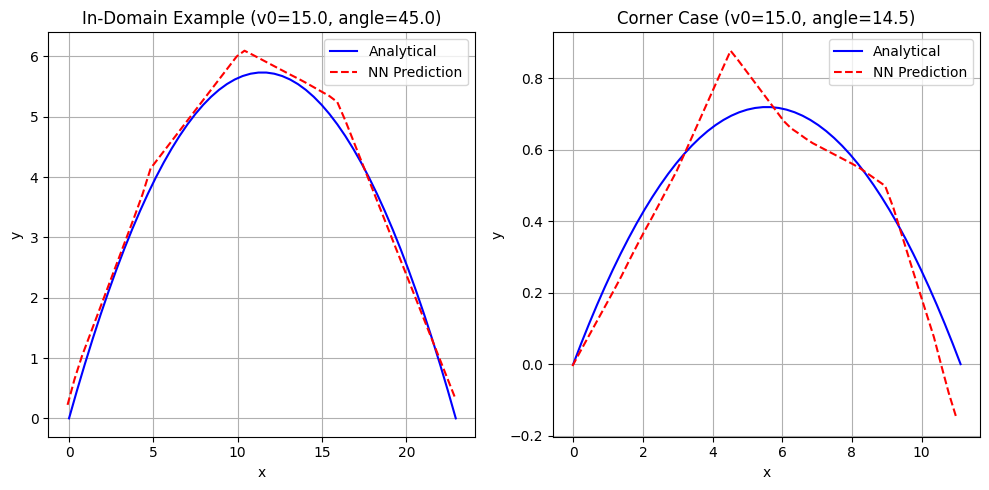

In [9]:
# 3b. Corner case: angle < training range
v0_corner = 15.0
angle_corner = 14.5
times_corner = np.linspace(0, 2 * v0_corner * np.sin(np.radians(angle_corner)) / 9.81, 50)

test_inputs_corner = []
for t in times_corner:
    test_inputs_corner.append([v0_corner, angle_corner, t])

test_inputs_corner = np.array(test_inputs_corner, dtype=np.float32)
nn_preds_corner = evaluate_model(model, test_inputs_corner)

# Ground truth for corner case
x_true_corner, y_true_corner = projectile_motion(v0_corner, angle_corner, times_corner)

# 4. Plot the results to visualize
plt.figure(figsize=(10, 5))

# 4a. Within Training Domain
plt.subplot(1, 2, 1)
plt.plot(x_true_in_domain, y_true_in_domain, 'b-', label='Analytical')
plt.plot(nn_preds_in_domain[:, 0], nn_preds_in_domain[:, 1], 'r--', label='NN Prediction')
plt.title(f'In-Domain Example (v0={v0_test}, angle={angle_test})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

# 4b. Corner Case
plt.subplot(1, 2, 2)
plt.plot(x_true_corner, y_true_corner, 'b-', label='Analytical')
plt.plot(nn_preds_corner[:, 0], nn_preds_corner[:, 1], 'r--', label='NN Prediction')
plt.title(f'Corner Case (v0={v0_corner}, angle={angle_corner})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()